In [157]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt

In [158]:
file = netCDF4.Dataset('../ocean_load_model/tidal_load_m2_10800_new_grad_new_mask.nc', 'r')

In [159]:
def open_simple_grid(filename = '../stations/LandOceanGrid_x_2.0_y_2.0_bounds_-89_89_0_360.txt'):
    with open(filename, 'r') as file:
        return np.array([line.split() for line in file.readlines()], dtype=float)
    
def polar2compl(magn, phase):
    r = magn*np.cos(phase)
    i = magn*np.sin(phase)
    return r, i

def compl2polar(real, imag):
    absv  = np.linalg.norm([real, imag])
    phase = np.arctan2(imag, real)
    phase = phase if imag > 0 else 2*np.pi + phase
    return absv, phase

In [160]:
N = 128
resolutions = set(np.logspace(0, 12, 13,base = 2, dtype=int)).union({10800})
assert N in resolutions, f'N needs to be in the following set: {resolutions}'

In [196]:
tidal_re  = np.array(file.variables            [f'tidal_elevation_re_lmax_{N}'][:])
tidal_im  = np.array(file.variables            [f'tidal_elevation_im_lmax_{N}'][:])
latitude  = np.array(file.variables [f'latitude_tidal_elevation_grad_lmax_{N}'][:])
longitude = np.array(file.variables[f'longitude_tidal_elevation_grad_lmax_{N}'][:])

compl = np.zeros_like(tidal_re, dtype=complex)
compl.real, compl.imag = tidal_re, tidal_im
absl = np.absolute(compl)
phase = np.angle(compl)

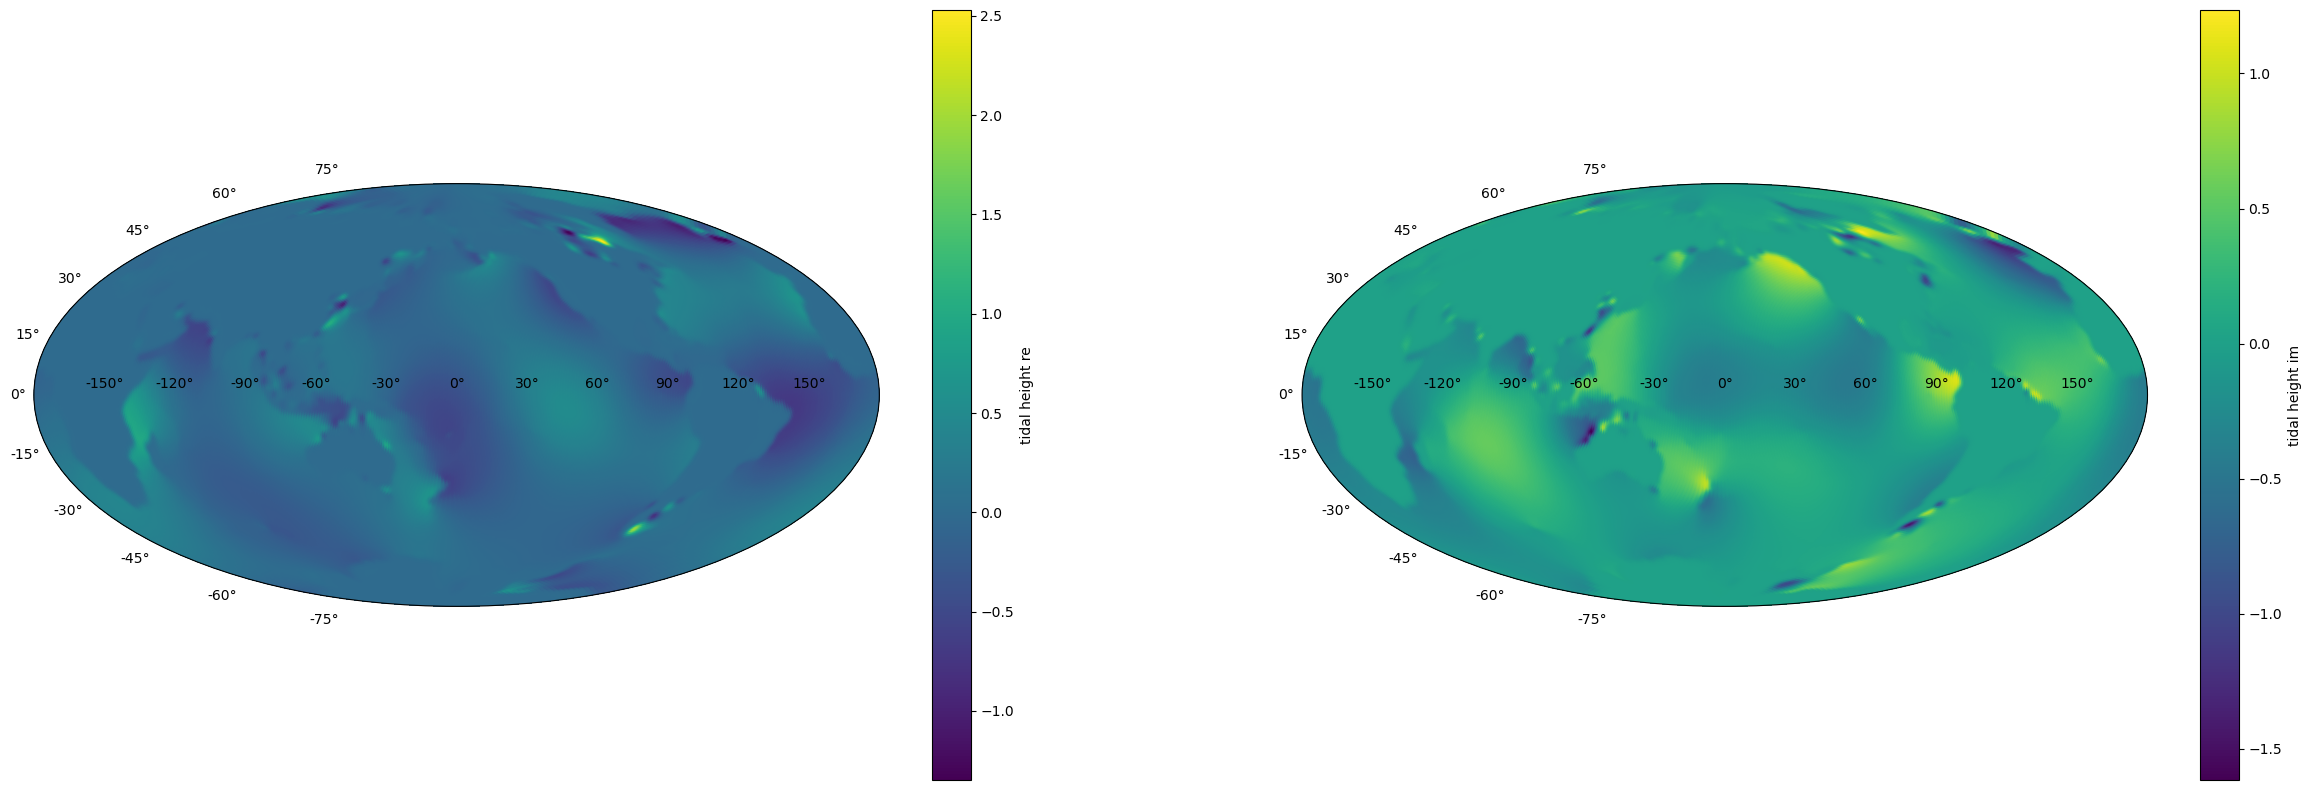

In [200]:
lat, lon = np.meshgrid(latitude, longitude)

fig, ax = plt.subplots(1,2,figsize=(30,10), subplot_kw={"projection":'aitoff'})
im = ax[0].scatter( np.radians(lon.flatten()-180), np.radians(lat.flatten()), c=tidal_re.flatten())
plt.colorbar(im, ax=ax[0], label=f'tidal height re')
im = ax[1].scatter( np.radians(lon.flatten()-180), np.radians(lat.flatten()), c=tidal_im.flatten())
plt.colorbar(im, ax=ax[1], label=f'tidal height im')

In [164]:
T_M2 = 12.42*3600.
omega_M2 = 2 * np.pi / T_M2
def load_at_time(t, A, Phi, omega ):
    return A * np.cos(omega*t - Phi)

In [165]:
ntsteps = 40
times = np.linspace(0., 2*T_M2, ntsteps)
timeshots = np.zeros((N, len(absl.flatten())))
for i, t in enumerate(times):
    timeshots[i] = load_at_time(t = t, A = absl.flatten(), Phi=phase.flatten(), omega = omega_M2)

In [205]:
for i in range(ntsteps):
    fig, ax = plt.subplots(figsize=(10,8), subplot_kw={"projection":'aitoff'})
    im = ax.scatter( np.radians(lon.flatten()-180), np.radians(lat.flatten()), c=timeshots[i])
    ax.grid()
    plt.savefig(f'./pic/t.{int(times[i])}.png')
    fig.colorbar(im, ax=ax, label=f't={times[i]} sec: tide height, m')
    plt.close()

In [206]:
import imageio.v3 as iio
import os

frames = np.stack(
    [iio.imread(f"./pic/t.{int(time)}.png") for time in times]
)
iio.imwrite('./pic/out.gif', frames,mode="RGBA")#, mode="I")